In [1]:
import numpy as np
import rasterio
import rasterio.mask
from rasterio.windows import Window
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.model_selection import train_test_split
import torch
import matplotlib as mpl
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

def transform_crs(dst_crs, resolution):

    input_paths = []
    output_paths = []

    # transition data
    for year_start, year_end in zip(np.arange(2000,2020),np.arange(2001,2021)):
        input_paths.append(f"../data/raw/biomass/amazonia/{resolution}m/additional/" + f"mapbiomas-brazil-collection-70-amazonia-{year_start}_{year_end}.tif")
        output_paths.append(f"../data/interim/biomass/amazonia/{resolution}m/additional/" + f"transition_{year_start}_{year_end}.tif")

    for input_path, output_path in zip(input_paths, output_paths):
        with rasterio.open(input_path) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            with rasterio.open(output_path, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
                    
# function to load biomass data
def load_biomass_data(year=None, year_end=None, folder="interim", shape=None, resolution=250, delta=None, name=None, additional=True):
    
    # determine the path to load from from
    if additional:
        path_bio = f"../data/{folder}/biomass/amazonia/{resolution}m/additional/" 
    else:
        path_bio = f"../data/{folder}/biomass/amazonia/{resolution}m/"
    if name is None:
        path_bio = path_bio + f"biomass_{year}.tif" if year_end is None else path_bio + f"transition_{year}_{year_end}.tif"
    else:
        path_bio = path_bio + name + ".tif"

    nodata = 255 if year_end is None else False

    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    bio_data = torch.from_numpy(bio_data)
    if delta is not None:
        diff_x = int((bio_data.shape[1]%delta)/2 + delta)
        diff_y = int((bio_data.shape[0]%delta)/2 + delta)
        bio_data = torch.nn.functional.pad(bio_data, (diff_y, diff_y, diff_x, diff_x), value=nodata)
    return bio_data, out_meta
                
# function to transform labels to 0=no-transition, 1=transition
def transform_transition_to_labels(transition_data):
    forest_labels = [1,3,4,5,49]
    deforestation_labels = [14,15,18,19,39,20,40,61,41,36,46,47,48,9,21,
                            22,23,24,30,25]
    transition_labels = []
    for forest_label in forest_labels:
        for deforestation_label in deforestation_labels:
            transition_labels.append(100*forest_label+deforestation_label)
    transition_data_new = np.zeros_like(transition_data, dtype=bool)
    for transition_label in transition_labels:
        transition_data_new[transition_data == transition_label] = True
    return transition_data_new

# function to transform labels to 0=forest, 1=natural, 2=farming, 3=urban, 4=water, 255=unknown
def transform_biodata_to_labels(bio_data):
    class_dict = {1:0, 3:0, 4:0, 5:0,49:0, # forest
                10:1,11:1,12:1,32:1,29:1,13:1, 13:1, 50:1, # natural
                14:2,15:2,18:2,19:2,39:2,20:2,40:2,61:2,41:2,36:2,46:2,47:2,48:2,9:2,21:2, # farming
                22:3,23:3,24:3,30:3,25:3, # urban
                26:4,33:4,31:4, # water
                27:255,0:255, 255:255} # unobserved
    bio_data_new = np.zeros_like(bio_data)
    for key, value in class_dict.items():
        bio_data_new[bio_data == key] = value
    return bio_data_new

def preprocess_data(dst_crs, resolution):
    # will transform all data to target crs and save
    transform_crs(dst_crs, resolution)

    # preprocess transition data
    for year_start, year_end in zip(np.arange(2000,2020),np.arange(2001,2021)):
        transition_data, out_meta = load_biomass_data(year_start, year_end)
        transition_data = transform_transition_to_labels(transition_data)
        with rasterio.open(f"../data/interim/biomass/amazonia/{resolution}m/additional/" + f"transition_{year_start}_{year_end}.tif", "w", **out_meta) as dest:
            dest.write(np.expand_dims(transition_data, axis=0))

In [72]:
dst_crs = 'EPSG:6933'
preprocess_data(dst_crs, 250)

# Calculate Deforestation rates

In [2]:
import geopandas as gpd
path = "../data/raw/biomass/Biomas_250mil/lm_bioma_250.shp"
df = gpd.read_file(path)
df['area_6933'] = df.geometry.to_crs("EPSG:6933").area / 10000

In [3]:
df

,Bioma,CD_Bioma,geometry,area_6933
0,Amazônia,1,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",4.215443e+08
1,Caatinga,2,"POLYGON ((-41.74080 -2.80826, -41.73673 -2.809...",8.626395e+07
2,Cerrado,3,"POLYGON ((-43.39009 -2.33937, -43.38741 -2.342...",1.984554e+08
3,Mata Atlântica,4,"MULTIPOLYGON (((-48.70814 -28.44851, -48.70994...",1.106845e+08
4,Pampa,5,"POLYGON ((-52.82472 -27.46295, -52.81558 -27.4...",1.939473e+07
5,Pantanal,6,"POLYGON ((-57.75946 -15.72779, -57.75659 -15.7...",1.509610e+07


In [4]:
df.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
# bio_data_2010, _ = load_biomass_data(2010, additional=False, folder="processed_transition")
bio_data_2010 = torch.load("../data/processed_transition/biomass/amazonia/250m/biomass_2010.pt")

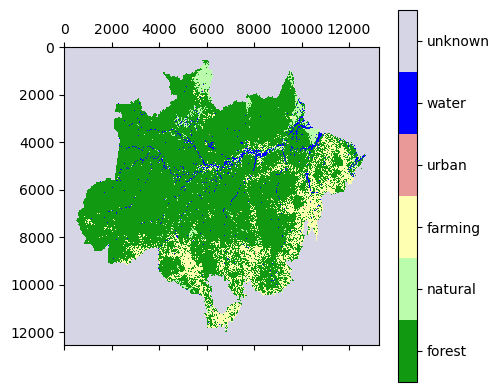

In [13]:
cmap = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
mat = plt.matshow(bio_data_2010,cmap=cmap,vmin = -.5, vmax = 5.5)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

In [5]:
def load_raw_data(year_start, year_end=None, shape=None, resolution=250):
    path_bio = f"../data/raw/biomass/amazonia/{resolution}m/"
    path_bio = path_bio + f"mapbiomas-brazil-collection-70-amazonia-{year_start}.tif" if year_end is None else path_bio + f"additional/mapbiomas-brazil-collection-70-amazonia-{year_start}_{year_end}.tif"
    nodata = 255 if year_end is None else False
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    bio_data = torch.from_numpy(bio_data)
    return bio_data, out_meta
bio_data_2010_untransformed, _ = load_raw_data(2010, year_end=None, shape=df[df.Bioma == "Amazônia"].geometry, resolution=250)
bio_data_2010_untransformed = transform_biodata_to_labels(bio_data_2010_untransformed)

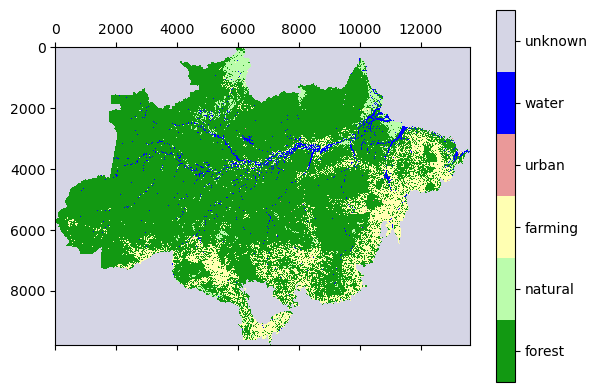

In [15]:
cmap = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
mat = plt.matshow(bio_data_2010_untransformed,cmap=cmap,vmin = -.5, vmax = 5.5)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

In [6]:
observed_px = np.count_nonzero(bio_data_2010_untransformed != 255)
# area_amazonia = int(df[df.Bioma == "Amazônia"].area_6933)
area_amazonia = 4196943 * 100
adapted_px_dim_untransform = np.sqrt(area_amazonia * 10000 / observed_px)
print("Area [ha] - reported online: ", 4196943 * 100)
print("Area [ha] - 250m px: ", observed_px * 250**2 / 10000)
print("Adpated pixel dim: ", adapted_px_dim_untransform)

Area [ha] - reported online:  419694300
Area [ha] - 250m px:  427199893.75
Adpated pixel dim:  247.7941083176385


In [9]:
observed_px = np.count_nonzero(bio_data_2010 != 255)
area_amazonia = int(df[df.Bioma == "Amazônia"].area_6933)
adapted_px_dim = np.sqrt(area_amazonia * 10000 / observed_px)
print("Area [ha] - reported online: ", 4196943 * 100)
print("Area [ha] - EPSG:6933: ", area_amazonia)
print("Area [ha] - 250m px: ", observed_px * 250**2 / 10000)
print("Adpated pixel dim: ", adapted_px_dim)

Area [ha] - reported online:  419694300
Area [ha] - EPSG:6933:  421544315
Area [ha] - 250m px:  452349718.75
Adpated pixel dim:  241.33730835579587


In [10]:
deforestation_rate = []
for year_start, year_end in zip(np.arange(2000,2020),np.arange(2001,2021)):
    transition_data, out_meta = load_biomass_data(year_start, year_end)
    deforestation_rate.append(torch.sum(transition_data) * adapted_px_dim**2 / 10000)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "rasterio/_base.pyx", line 308, in rasterio._base.DatasetBase.__init__
  File "rasterio/_base.pyx", line 219, in rasterio._base.open_dataset
  File "rasterio/_err.pyx", line 221, in rasterio._err.exc_wrap_pointer
rasterio._err.CPLE_OpenFailedError: ../data/interim/biomass/amazonia/250m/additional/transition_2000_2001.tif: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/sp/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/nz/fyqhwzv1271gch4y19rxtnwc0000gn/T/ipykernel_2620/3904001833.py", line 3, in <module>
    transition_data, out_meta = load_biomass_data(year_start, year_end)
  File "/var/folders/nz/fyqhwzv1271gch4y19rxtnwc0000gn/T/ipykernel_2620/2701852132.py", line 60, in load_biomass_data
    with ra

In [11]:
deforestation_rate_raw = []
for year_start, year_end in zip(np.arange(2000,2020),np.arange(2001,2021)):
    transition_data, out_meta = load_raw_data(year_start, year_end)
    transition_data = transform_transition_to_labels(transition_data)
    deforestation_rate_raw.append(np.sum(transition_data) * adapted_px_dim_untransform**2 / 10000)

In [12]:
reported = [1658674.60, 1886757.99, 2569816.57, 2241427.52, 1856240.31, 1358708.47, 1040013.11, 969637.09, 531704.23, 463594.51, 547810.70,470476.73, 574083.73,544083.04,705946.23,895557.06,694287.44,792901.58,740159.18,710286.58]

# Deforestation data

In [21]:
def transform_crs(dst_crs, resolution):

    input_paths = []
    output_paths = []

    # transition data
    for year in np.arange(2000,2020):
        input_paths.append(f"../data/raw/biomass/amazonia/{resolution}m/deforestation/" + f"mapbiomas-brazil-collection-70-amazonia-{year}.tif")
        output_paths.append(f"../data/interim/biomass/amazonia/{resolution}m/deforestation/" + f"deforestation_{year}.tif")

    for input_path, output_path in zip(input_paths, output_paths):
        with rasterio.open(input_path) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            with rasterio.open(output_path, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)

In [93]:
transform_crs('EPSG:6933', 250)

In [13]:
def load_deforestation_data(year, shape=None, resolution=250, folder="raw"):
    path_bio = f"../data/{folder}/biomass/amazonia/{resolution}m/deforestation/"
    path_bio = path_bio + f"mapbiomas-brazil-collection-70-amazonia-{year}.tif" if folder == "raw" else path_bio + f"deforestation_{year}.tif"
    nodata = 750
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    # bio_data = torch.from_numpy(bio_data)
    return bio_data, out_meta

In [14]:
deforestation_2019, _ = load_deforestation_data(2019)
deforestation_2019 = (deforestation_2019/100).astype(np.uint8)

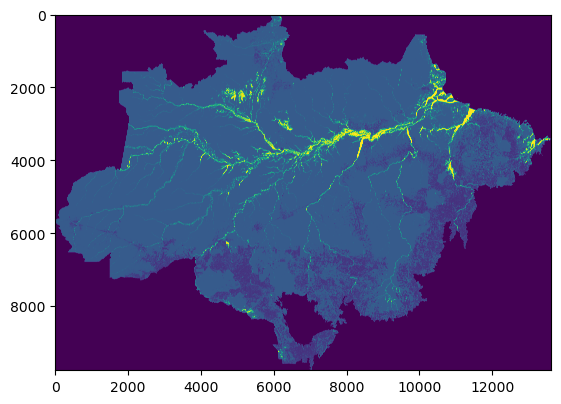

In [15]:
plt.imshow(deforestation_2019)
plt.show()

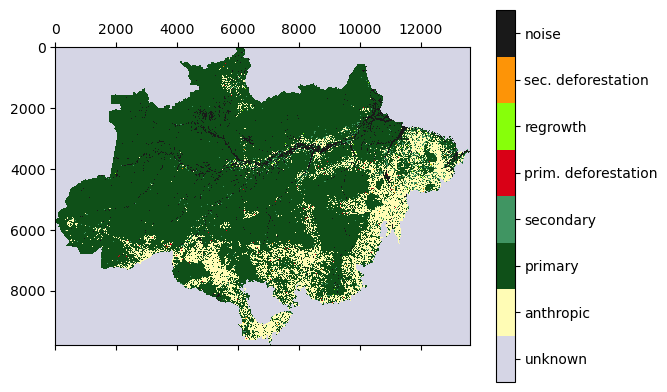

In [25]:
cmap = colors.ListedColormap(['#D5D5E5', '#FFFCB5','#0F5018', '#409562', '#D90016', '#87FF0A', '#FD9407', '#191919'])
mat = plt.matshow(deforestation_2019,cmap=cmap,vmin = -.5, vmax = 7.5)
cax = plt.colorbar(mat, ticks=np.arange(0,8))
cax.ax.set_yticklabels(['unknown', 'anthropic', 'primary', 'secondary', 'prim. deforestation', 'regrowth', 'sec. deforestation', 'noise'])
plt.show()

In [16]:
deforestation_rate_new_raw = []
for year in np.arange(2000,2020):
    deforestation, _ = load_deforestation_data(year)
    deforestation = (deforestation/100).astype(np.uint8)
    deforestation_rate_new_raw.append(np.count_nonzero(deforestation == 4) * adapted_px_dim_untransform**2 / 10000)

deforestation_rate_new = []
for year in np.arange(2000,2020):
    deforestation, _ = load_deforestation_data(year, folder="interim")
    deforestation = (deforestation/100).astype(np.uint8)
    deforestation_rate_new.append(np.count_nonzero(deforestation == 4) * adapted_px_dim**2 / 10000)

# Deforestation 30m

In [17]:
from rasterio.merge import merge
# function to load biomass data
def load_mosaic_data(year=None, folder="raw", shape=None, resolution=30, delta=None):
    
    
    path_bio = f"../data/{folder}/biomass/amazonia/{resolution}m/deforestation/" 

    path_bios = [path_bio + name for name in os.listdir(path_bio) if f"-{year}-" in name]
    
    src_files_to_mosaic = []
    for fp in path_bios:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    mosaic, out_trans = merge(src_files_to_mosaic)
    # bio_data = torch.from_numpy(mosaic)
    return mosaic, out_trans

In [32]:
bio_data, meta = load_mosaic_data(year=2018)

In [33]:
bio_data = bio_data.squeeze()
bio_data = (bio_data/100).astype(np.uint8)

In [34]:
biodata_bool = torch.from_numpy(bio_data == 4).type(torch.bool)

In [35]:
torch.save(biodata_bool, "../data/processed_deforestation/biomass/amazonia/30m/deforestation/deforestation_2018.pt")

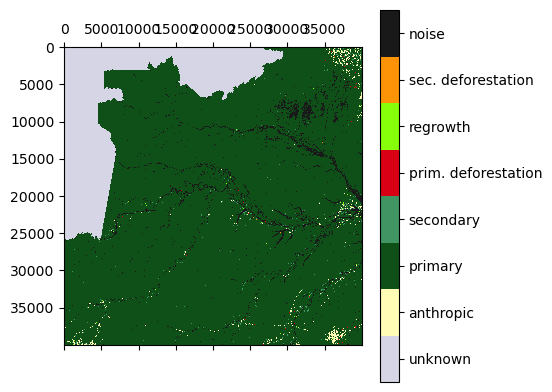

In [20]:
cmap = colors.ListedColormap(['#D5D5E5', '#FFFCB5','#0F5018', '#409562', '#D90016', '#87FF0A', '#FD9407', '#191919'])
mat = plt.matshow(bio_data[10000:50000,10000:50000],cmap=cmap,vmin = -.5, vmax = 7.5)
cax = plt.colorbar(mat, ticks=np.arange(0,8))
cax.ax.set_yticklabels(['unknown', 'anthropic', 'primary', 'secondary', 'prim. deforestation', 'regrowth', 'sec. deforestation', 'noise'])
plt.show()

In [36]:
observed_px = np.count_nonzero(bio_data != 0)
area_amazonia = 4196943 * 100
adapted_px_dim_untransform_30m = np.sqrt(area_amazonia * 10000 / observed_px)
print(adapted_px_dim_untransform_30m)

29.742292199735356


In [38]:
deforestation_rate_30m = []
for year in range(1995,2020):
    bio_data, meta = load_mosaic_data(year=year)
    bio_data = bio_data.squeeze()
    bio_data = (bio_data/100).astype(np.uint8)
    biodata_bool = torch.from_numpy(bio_data == 4).type(torch.bool)
    torch.save(biodata_bool, f"../data/processed_deforestation/biomass/amazonia/30m/deforestation/deforestation_{year}.pt")
    deforestation_rate_30m.append(np.count_nonzero(bio_data == 4) * adapted_px_dim_untransform_30m**2 / 10000)
print(deforestation_rate_30m)

737571.5109618581

[2212897.4529846855, 1756159.8939353898, 1874783.0714895108, 1859633.6097035815, 1656123.1298758504, 1487764.1570222836, 1661336.6316878377, 1892704.5281984142, 2580316.6401379965, 2247802.420839297, 1860943.9735277465, 1359323.5564228906, 1039638.8366031912, 969597.134660301, 530635.4265105134, 462718.4547838259, 548878.7021347152, 470692.09782592085, 574193.9439995734, 543676.6117136222, 705528.5264059972, 893338.9669522486, 693857.7696349386, 792071.3649632264, 739491.3025984756]


# Compare

In [40]:
import pandas as pd
deforestation_df_1 = pd.DataFrame({
    "year": np.arange(2001,2021),
    "deforestation [ha]": reported,
    "source": ["reported"] * len(reported)})
'''
deforestation_df_2 = pd.DataFrame({
    "year": np.arange(2001,2021),
    "deforestation [ha]": deforestation_rate,
    "source": ["calculated"] * len(deforestation_rate)})
'''
deforestation_df_3 = pd.DataFrame({
    "year": np.arange(2001,2021),
    "deforestation [ha]": deforestation_rate_raw,
    "source": ["transition data 250m"] * len(deforestation_rate_raw)})
deforestation_df_4 = pd.DataFrame({
    "year": np.arange(2000,2020),
    "deforestation [ha]": deforestation_rate_new_raw,
    "source": ["deforestation data 250m"] * len(deforestation_rate_new_raw)})
deforestation_df_5 = pd.DataFrame({
    "year": np.arange(2000,2020),
    "deforestation [ha]": deforestation_rate_new,
    "source": ["deforestation trans"] * len(deforestation_rate_new)})
deforestation_df_6 = pd.DataFrame({
    "year": np.arange(1995,2020),
    "deforestation [ha]": deforestation_rate_30m,
    "source": ["deforestation data 30m"] * len(deforestation_rate_30m)})
deforestation_df = pd.concat([deforestation_df_1, deforestation_df_3, deforestation_df_4, deforestation_df_6])

In [49]:
# save deforestation_df as csv in report folder
deforestation_df.to_csv("../reports/deforestation.csv", index=False)

In [2]:
import pandas as pd
deforestation_df = pd.read_csv("../reports/deforestation.csv")

In [8]:
import plotly.express as px
fig = px.line(deforestation_df, x="year", y="deforestation [ha]", color="source", title="Deforestation in Amazonian Biome in year before")
# add markers to points
fig.update_traces(mode='lines+markers')
# make lines see-through
fig.update_traces(line=dict(width=1, dash='dot'))
fig.show()
# save figure with dpi 200
fig.write_image("../reports/figures/deforestation_rate.png", scale=2)

In [31]:
transition_2009_2010, _ = load_biomass_data(2009, 2010, additional=False)
transition_2005_2010, _ = load_biomass_data(2005, 2010, additional=False)
transition_2010_2015, _ = load_biomass_data(2010, 2015, additional=False)
transition_2000_2010, _ = load_biomass_data(2000, 2010, additional=False)
print("Aggregated Layer - 2009-2010: ", torch.sum(transition_2009_2010).item()* adapted_px_dim**2 / 10000)
print("Individual Sum   - 2009-2010: ", np.sum(deforestation_rate[9:10]))
print("Aggregated Layer - 2005-2010: ", torch.sum(transition_2005_2010).item()* adapted_px_dim**2 / 10000)
print("Individual Sum   - 2005-2010: ", np.sum(deforestation_rate[5:10]))
print("Aggregated Layer - 2010-2015: ", torch.sum(transition_2010_2015).item()* adapted_px_dim**2 / 10000)
print("Individual Sum   - 2010-2015: ", np.sum(deforestation_rate[10:15]))
print("Aggregated Layer - 2000-2010: ", torch.sum(transition_2000_2010).item()* adapted_px_dim**2 / 10000)
print("Individual Sum   - 2000-2010: ", np.sum(deforestation_rate[0:10]))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "rasterio/_base.pyx", line 308, in rasterio._base.DatasetBase.__init__
  File "rasterio/_base.pyx", line 219, in rasterio._base.open_dataset
  File "rasterio/_err.pyx", line 221, in rasterio._err.exc_wrap_pointer
rasterio._err.CPLE_OpenFailedError: ../data/interim/biomass/amazonia/250m/transition_2009_2010.tif: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/sp/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/nz/fyqhwzv1271gch4y19rxtnwc0000gn/T/ipykernel_1850/2107254868.py", line 1, in <module>
    transition_2009_2010, _ = load_biomass_data(2009, 2010, additional=False)
  File "/var/folders/nz/fyqhwzv1271gch4y19rxtnwc0000gn/T/ipykernel_1850/2701852132.py", line 60, in load_biomass_data
    with rasteri